In [67]:
# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [68]:
import os
import subprocess

import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import time

Making Dataloaders

In [69]:
class RandomGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std
        
    def __call__(self, image):
        return image + torch.randn(image.size()) * self.std + self.mean

def load_example(df_row):
    image = torchvision.io.read_image(df_row['image_path'])
    
    result = {
        'image': image,
        'class': df_row['Class']
    }
    return result

In [70]:
class HiddenDataset(Dataset):
    def __init__(self, split='train' , aug = True):
        super().__init__()
        self.examples = []
        self.transform = None
        
        if split == 'retain' or split == 'forget':
            from torchvision import transforms
            if aug:
                self.transform = transforms.Compose([
                    RandomGaussianNoise(mean=0.0, std=0.1), # Add Data Augmentation (Random Gaussian Noise)
                ])
        df = pd.read_csv(f'FashionMNIST/{split}_mini.csv')
        df['image_path'] = df['Image_File'].apply(
            lambda x: os.path.join('FashionMNIST/train/', x))
        df = df.sort_values(by='image_path')
        df.apply(lambda row: self.examples.append(load_example(row)), axis=1)
        if len(self.examples) == 0:
            raise ValueError('No examples.')

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        image = example['image']
        image = image.to(torch.float32)
        if self.transform is not None:
            image = self.transform(image)
        example['image'] = image
        return example

In [71]:
def get_dataset(batch_size , aug = True):
    train_ds = HiddenDataset(split='train' , aug = aug)
    retain_ds = HiddenDataset(split='retain' , aug = aug)
    forget_ds = HiddenDataset(split='forget' , aug = aug)

    retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True)
    forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    return retain_loader, forget_loader, train_loader

Training ResNet18

In [72]:
retain_loader, forget_loader, train_loader = get_dataset(64 , True)

In [73]:
# model = resnet18(pretrained=False, num_classes=10) 

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# num_epochs = 15

# for epoch in range(num_epochs):
#     model.train()
#     for i , sample in enumerate(train_loader):

#         inputs = sample["image"]
#         labels = sample["class"]
#         optimizer.zero_grad()

#         # Make 3 channels for RGB
#         inputs = torch.cat((inputs, inputs, inputs), 1)

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# checkpoint_path = 'learned_resnet.pth'
# torch.save(model.state_dict(), checkpoint_path)

In [74]:
def accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images = data['image']
            images = torch.cat((images, images, images), dim=1)
            labels = data['class']
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

In [75]:
# accuracy(model, train_loader)

Unlearning

In [76]:
acc_retain_unlearned = []
acc_forget_unlearned = []

In [77]:
def unlearning(
    net,
    retain_loader,
    forget_loader):
    cycles = 4              # number of cycles
    epochs = [3, 2, 1, 1]   # epochs for each cycle
    num_init = [1, 1, 1, 0] # number of re-initializing parameters for each cycle, 1/10 of the model parameters (layer level)
    
    acc_retain_unlearned.append(accuracy(net, retain_loader))
    acc_forget_unlearned.append(accuracy(net, forget_loader))

    # Clone the original model with requires_grad=False
    from copy import deepcopy
    cloned_net = deepcopy(net)
    for param in cloned_net.parameters():
        param.requires_grad = False
        
    # Knowledge Preserving Loss (MSE loss) used in Remembering Phase
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    
    # Custom lr scheduling
    def adjust_lr(epoch):
        # # base_lr * lambda
        # # last additional element 0 for preventing indexing error at the last scheduler.step()
        # lambda_list = [0.5, 1, 1, 1, 1, 0] # make lr=[0.0005, 0.001, 0.001, 0.001, 0.001] for each epoch
        # return lambda_list[epoch]
        return 1
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=adjust_lr)
    net.train()

    # Setting seleciton pool, which will be selected to be re-initialized in Forgetting Phase
    params = [p for p in net.named_parameters() if 'downsample' not in p[0] and 'fc' not in p[0]] # do not re-initialize FC and Downsample

    import random
    from tqdm import tqdm
    for cycle in range(cycles):
        # print(f"Cycle {cycle+1} starts")
        ### Forgetting Phase: Stochastic Re-initialization ###
        # Randomly reinitialize part of the network parameters (layer level)
        with torch.no_grad():
            for _ in range(num_init[cycle]):
                name, param = random.choice(params) # Sampling with replacement
                if 'weight' in name:
                    nn.init.normal_(param, mean=0, std=0.01) # Using normal distribution for initialization
                elif 'bias' in name:
                    nn.init.zeros_(param) # Initializing biases to zero

        ### Remembering Phase: Knowledge Preserving Loss ###
        # Remind the model about retain set
        # Only retain set is utilized
        for ep in tqdm(range(epochs[cycle]) , desc=f"Cycle {cycle+1}"):
            for i , sample in enumerate(retain_loader):
                inputs = sample["image"]
                # Resize the inputs to have 3 channels having the same values

                inputs = torch.cat((inputs, inputs, inputs), dim=1)
                optimizer.zero_grad()
                targets = cloned_net(inputs)
                outputs = net(inputs)
                loss = criterion(outputs, targets) # Calculate loss between original model output and unlearned model output
                loss.backward()
                optimizer.step()
            scheduler.step()
            
            acc_retain_unlearned.append(accuracy(net, retain_loader))
            acc_forget_unlearned.append(accuracy(net, forget_loader))
                
    net.eval()

In [78]:
original_net = resnet18(weights=None, num_classes=10)
original_net.load_state_dict(torch.load('learned_resnet.pth'))

unleaned_net = resnet18(weights=None, num_classes=10)
unleaned_net.load_state_dict(torch.load('learned_resnet.pth'))

start = time.process_time()
unlearning(unleaned_net, retain_loader, forget_loader)
time_unlearned = (time.process_time() - start)

state = unleaned_net.state_dict()
torch.save(state, 'unlearned_resnet_knowledge_preserving.pth')

Cycle 4: 100%|██████████| 1/1 [00:08<00:00,  8.72s/it]


In [79]:
acc_forget_retain = []
acc_retain_retain = []

In [80]:
retain_loader, forget_loader, train_loader = get_dataset(64 , False)

retained_net = resnet18(pretrained=False, num_classes=10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(retained_net.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10

acc_forget_retain.append(accuracy(retained_net, forget_loader))
acc_retain_retain.append(accuracy(retained_net, retain_loader))

start = time.process_time()
for epoch in range(num_epochs):
    retained_net.train()
    for i, sample in enumerate(retain_loader):

        inputs = sample["image"]
        labels = sample["class"]
        optimizer.zero_grad()

        # Make 3 channels for RGB
        inputs = torch.cat((inputs, inputs, inputs), 1)

        outputs = retained_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    acc_forget_retain.append(accuracy(retained_net, forget_loader))
    acc_retain_retain.append(accuracy(retained_net, retain_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

time_retained = (time.process_time() - start)

checkpoint_path = "retained_resnet.pth"
torch.save(retained_net.state_dict(), checkpoint_path)

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.667764902114868
Epoch 2/10, Loss: 2.3439440727233887
Epoch 3/10, Loss: 2.2864646911621094
Epoch 4/10, Loss: 1.9600452184677124
Epoch 5/10, Loss: 1.7709879875183105
Epoch 6/10, Loss: 1.5097627639770508
Epoch 7/10, Loss: 1.4590433835983276
Epoch 8/10, Loss: 0.9674039483070374
Epoch 9/10, Loss: 0.7556551694869995
Epoch 10/10, Loss: 0.637669563293457


In [81]:
print("Original Model Accuracy on Retained Set:" , accuracy(original_net, retain_loader))
print("Original Model Accuracy on Forget Set:" , accuracy(original_net, forget_loader))

print("Unlearned Model Accuracy on Retained Set:" , accuracy(unleaned_net, retain_loader))
print("Unlearned Model Accuracy on Forget Set:" , accuracy(unleaned_net, forget_loader))

print("Retained Model Accuracy on Retained Set:" , accuracy(retained_net, retain_loader))
print("Retained Model Accuracy on Forget Set:" , accuracy(retained_net, forget_loader))

Original Model Accuracy on Retained Set: 99.5
Original Model Accuracy on Forget Set: 98.0
Unlearned Model Accuracy on Retained Set: 42.0
Unlearned Model Accuracy on Forget Set: 14.5
Retained Model Accuracy on Retained Set: 99.25
Retained Model Accuracy on Forget Set: 8.5


In [82]:
# Print the time taken for unlearning and retaining
print(f"Time taken for unlearning: {time_unlearned}")
print(f"Time taken for retaining: {time_retained}")

Time taken for unlearning: 174.46875
Time taken for retaining: 185.40625


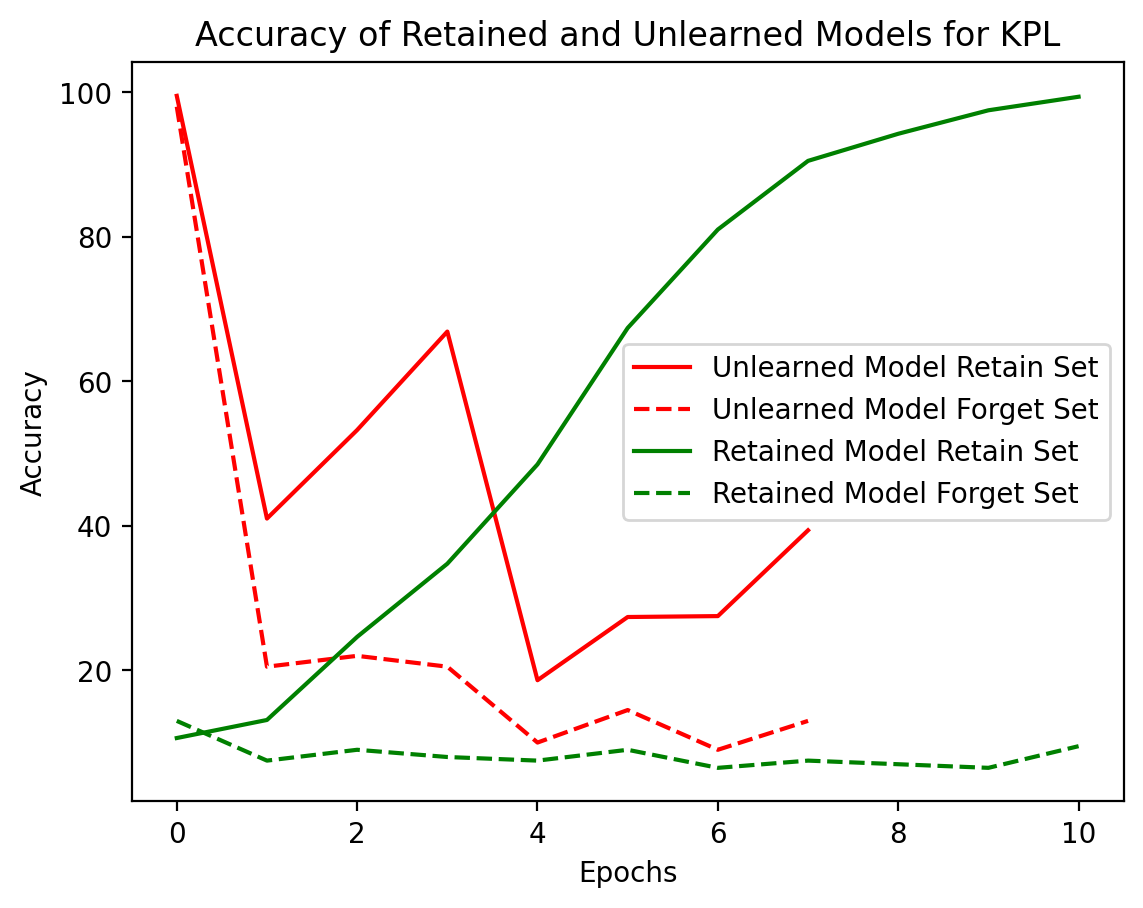

In [83]:
# Plot the accuracy of the models
import matplotlib.pyplot as plt

plt.plot(acc_retain_unlearned, label="Unlearned Model Retain Set" , color = 'red')
plt.plot(acc_forget_unlearned, label="Unlearned Model Forget Set" , color = 'red' , linestyle = 'dashed')
plt.plot(acc_retain_retain, label="Retained Model Retain Set" , color = 'green')
plt.plot(acc_forget_retain, label="Retained Model Forget Set" , color = 'green' , linestyle = 'dashed')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy of Retained and Unlearned Models for KPL")
plt.savefig("posterimgs/acc_kpl.png")
plt.show()

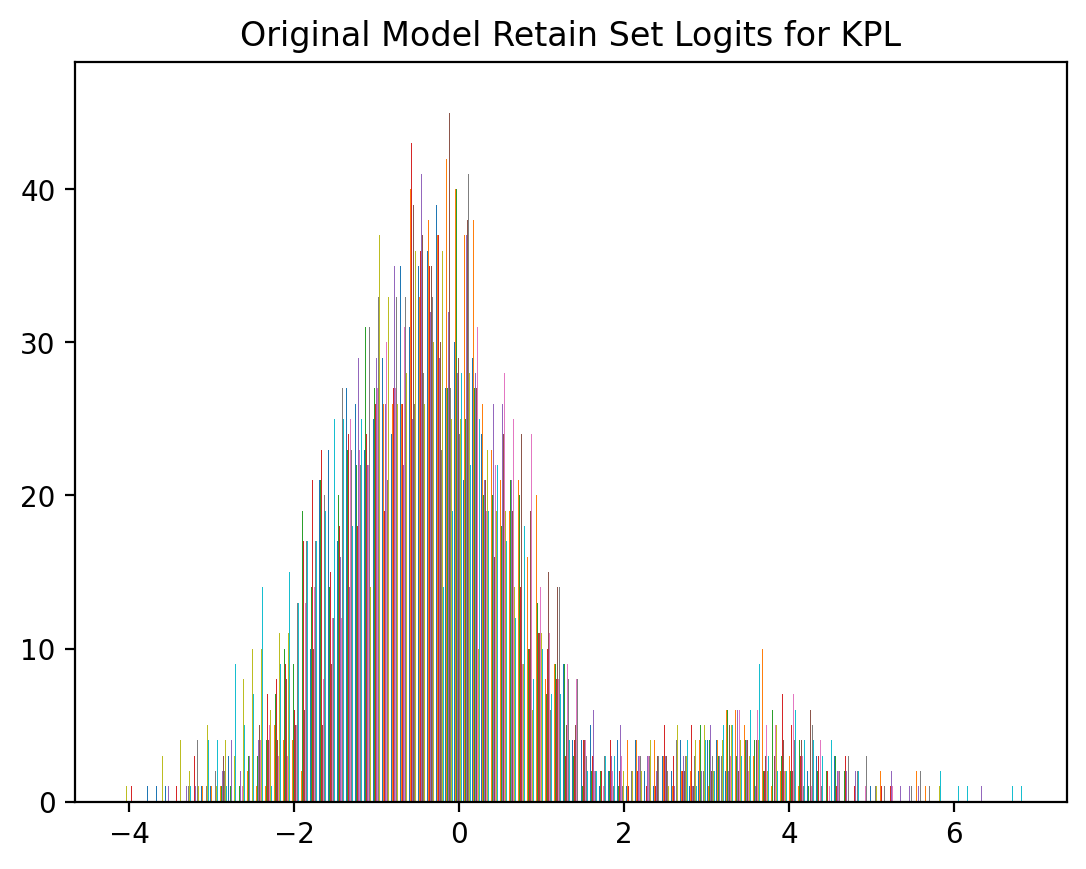

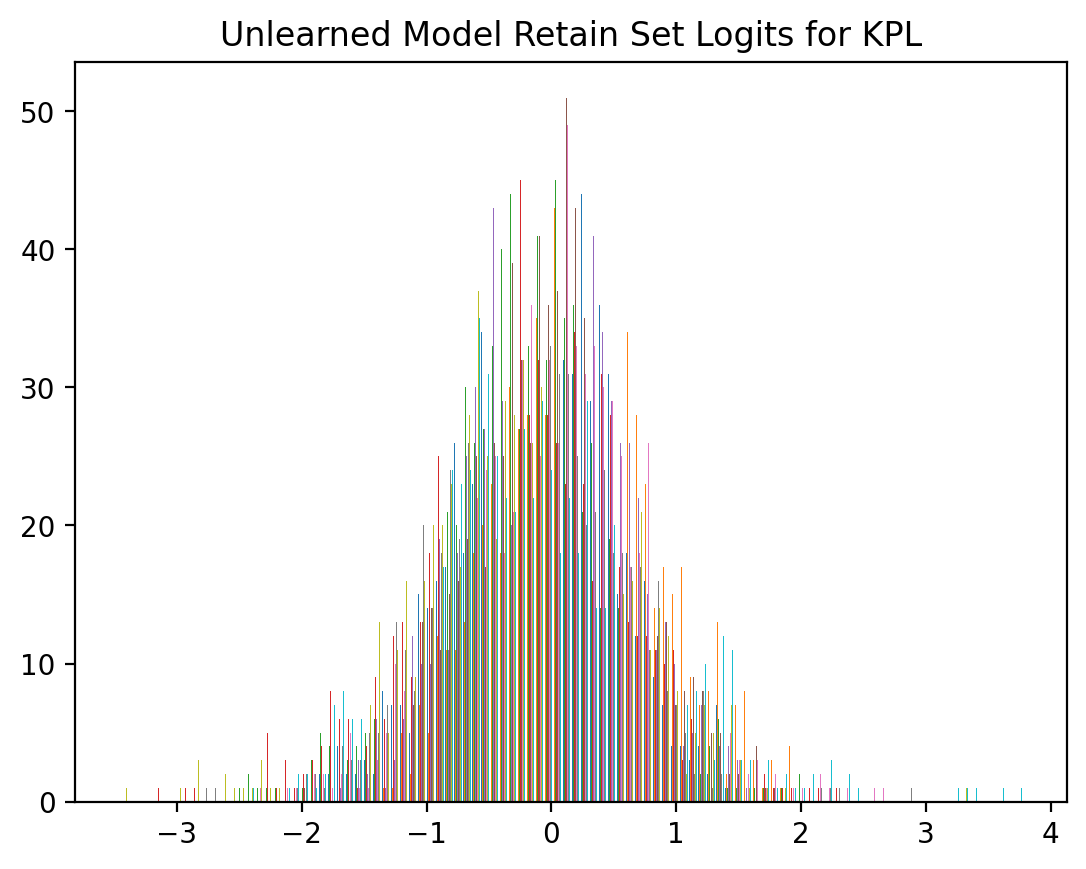

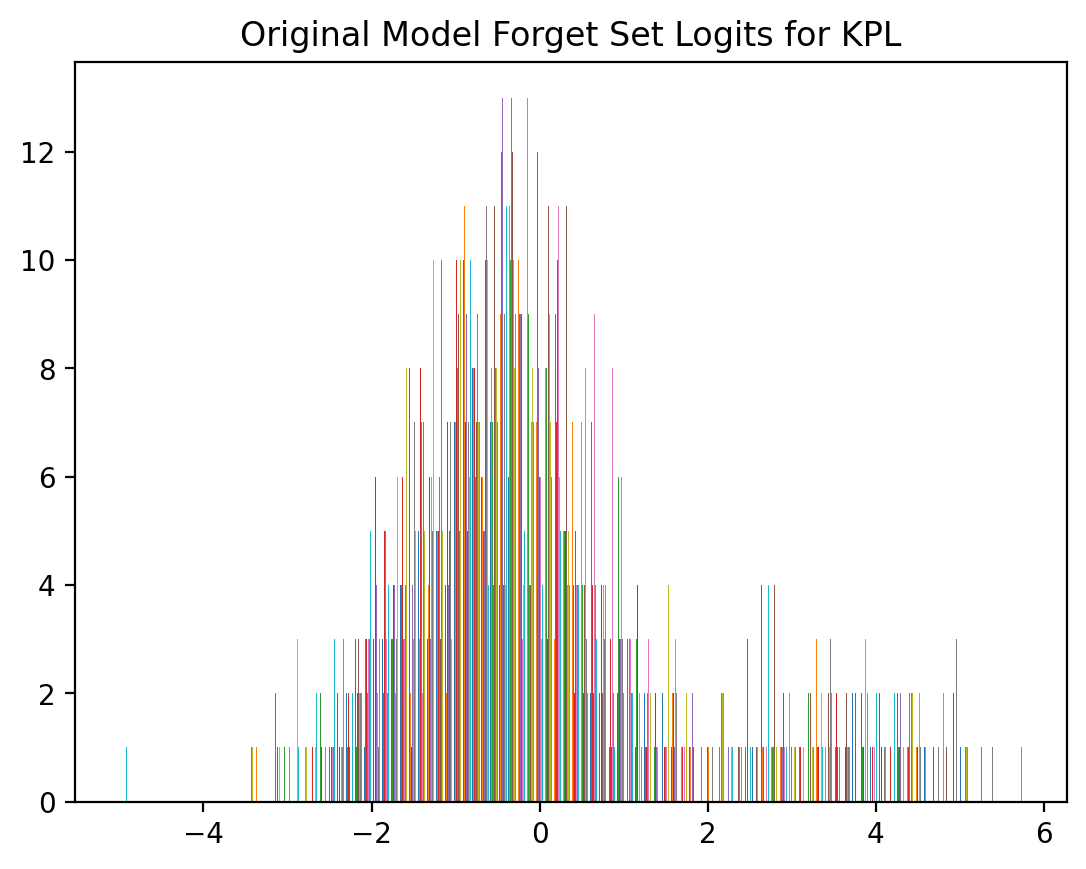

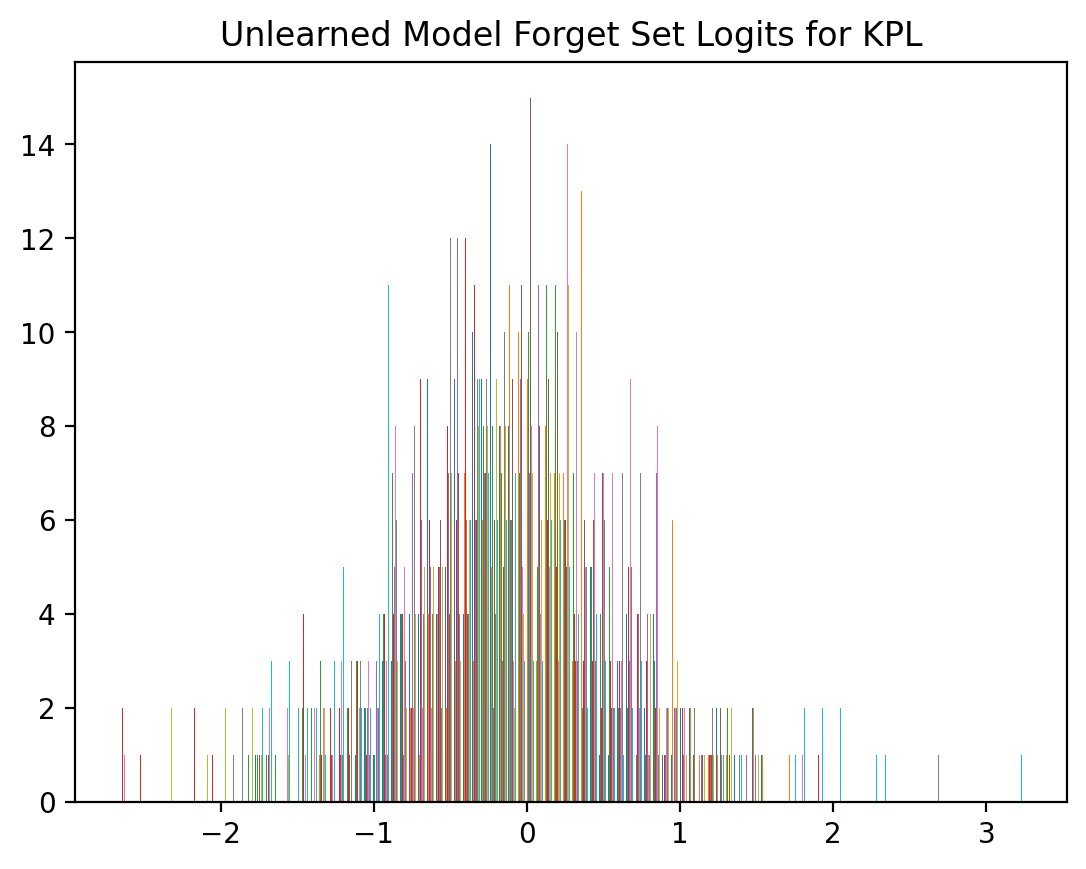

In [84]:
# Plot a histogram of logits for the retained set of the original model and the unlearned model
import matplotlib.pyplot as plt
import numpy as np

def plot_logits(net, dataloader , title , name):
    logits = []
    with torch.no_grad():
        for data in dataloader:
            images = data['image']
            images = torch.cat((images, images, images), dim=1)
            labels = data['class']
            outputs = net(images)
            logits.extend(outputs.numpy())
    logits = np.array(logits)
    plt.hist(logits, bins=100)
    plt.title(title)
    path = f"posterimgs/{name}.png"
    plt.savefig(path)
    plt.show()

plot_logits(original_net, retain_loader , "Original Model Retain Set Logits for KPL" , "original_retain_logits_kpl")
plot_logits(unleaned_net, retain_loader , "Unlearned Model Retain Set Logits for KPL" , "unlearned_retain_logits_kpl")

# Plot a histogram of logits for the forget set of the original model and the unlearned model
plot_logits(original_net, forget_loader , "Original Model Forget Set Logits for KPL" , "original_forget_logits_kpl")
plot_logits(unleaned_net, forget_loader , "Unlearned Model Forget Set Logits for KPL" , "unlearned_forget_logits_kpl")